# Подключение библиотек

In [9]:
import time
import random
import os
from PIL import Image # импортируем модель Image для работы с изображениями

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Add, Conv2DTranspose, concatenate, Activation, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D, UpSampling2D, Conv2D, BatchNormalization, Reshape, Flatten, ReLU, LeakyReLU
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями

from google.colab import files # Импортируем Модуль files для работы с файлами

In [10]:
from google.colab import drive # Подключаем гугл-диск
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Настройки

In [11]:
# Глобальные параметры
IMG_WIDTH = 240 # Ширина уменьшенной картинки 
IMG_HEIGHT = 176 # Высота уменьшенной картинки 
NUM_CLASSES = 2 # Количество классов изображения
AIRPLANE_DIR = '/content/drive/MyDrive/Colab Notebooks/ОБУЧЕНИЕ/УИИ/14. Сегментация изображений/files/самолёты/Airplane'
SEGMENT_DIR = '/content/drive/MyDrive/Colab Notebooks/ОБУЧЕНИЕ/УИИ/14. Сегментация изображений/files/самолёты/Segment'

# Изображения

In [12]:
# --- Airplane ---
airplane_list = []

for filename in sorted(os.listdir(AIRPLANE_DIR)): 
  img = image.load_img(
      path = os.path.join(AIRPLANE_DIR , filename), 
      color_mode='rgb', 
      target_size=(IMG_HEIGHT, IMG_WIDTH),
  )
  np_img = image.img_to_array(img)/255
  airplane_list.append(np_img)

x_data = np.array(airplane_list)
print('X DATA SHAPE:', x_data.shape)


# --- Segment ---
segment_list = []

for filename in sorted(os.listdir(SEGMENT_DIR)): 
  img = image.load_img(
      path = os.path.join(SEGMENT_DIR, filename), 
      color_mode='rgb', 
      target_size=(IMG_HEIGHT, IMG_WIDTH),
  )
  np_img = image.img_to_array(img)/255
  segment_list.append(np_img)

y_segment = np.array(segment_list)
print('Y SEGMENT SHAPE:', y_segment.shape)


X DATA SHAPE: (1000, 176, 240, 3)
Y SEGMENT SHAPE: (1000, 176, 240, 3)


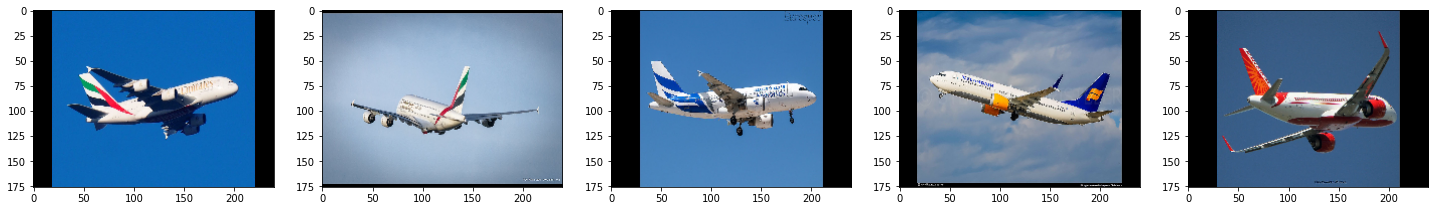

In [17]:
rand_count = 5  # Количество случайных изображений
indexes = np.random.randint(0, x_data.shape[0], rand_count)  # Получаем rand_count случайных индексов

n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) #Создаем полотно из n графиков

for i, idx in enumerate(indexes): # Выводим в цикле n случайных изображений
  img = x_data[idx]
  axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

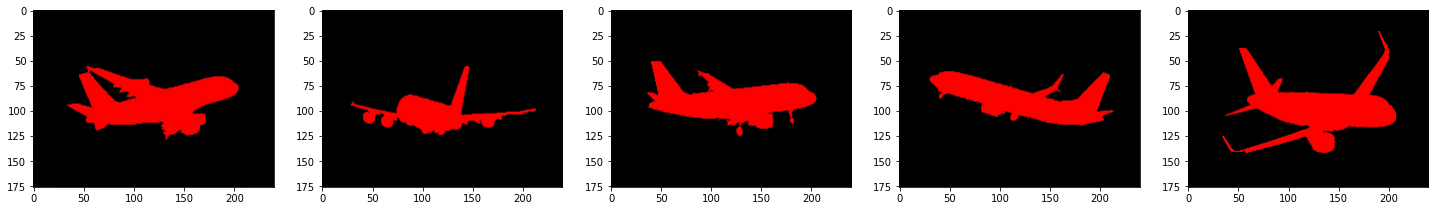

In [19]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i, idx in enumerate(indexes): # Выводим в цикле n случайных изображений
  img = y_segment[idx] # Выбираем случайное фото для отображения
  axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

# Функции

In [20]:
# Цвет пикселя -> в индекс.
def color_to_index(color):
  return 1 if (color[0] + color[1] + color[2]) > 0.5 else 0


# Индекс преобразуем в цвет
def index_to_color(index):
  return [0, 0, 0] if index == 0 else [255, 0, 0]


# Изображение в "one hot eccoding" вектор, где вместо пикселя стоит "one hot eccoding" вектор
def img_to_categorical(img):
  p_list = []  # Список, в котором вместо пикселя стоит "one hot eccoding" вектор
  for row in range(img.shape[0]):  # Проходим по строкам
    for col in range(img.shape[1]):  # Проходим по строкам
      cat = to_categorical(color_to_index(img[row, col]), num_classes=NUM_CLASSES)
      p_list.append(cat)

  tensor = np.array(p_list)
  return tensor.reshape(img.shape[0], img.shape[1], NUM_CLASSES)  # Возвращаем тензор похожий на изображения, но вместо каналов цвета - "one hot eccoding" вектор


# Создание y_train
def create_y_train(segment):
  y_train_list = []

  for img in segment:  # Проходим по всем файлам сегментированных изображений
    img_one_hot = img_to_categorical(img)  # Тензор похожий на изображения, но вместо каналов цвета - "one hot eccoding" вектор
    y_train_list.append(img_one_hot)

  return np.array(y_train_list)


# Собственная функция метрики, вычисляет пересечение двух областей
def dice_coef(y_true, y_pred):
  return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

# Создание x_train, y_train

In [21]:
print('X_DATA', x_data.shape)
y_data = create_y_train(y_segment) 
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1)
print('X_TRAIN', x_train.shape)
print('Y_TRAIN', y_train.shape)

X_DATA (1000, 176, 240, 3)
X_TRAIN (900, 176, 240, 3)
Y_TRAIN (900, 176, 240, 2)


# Модель PSPNet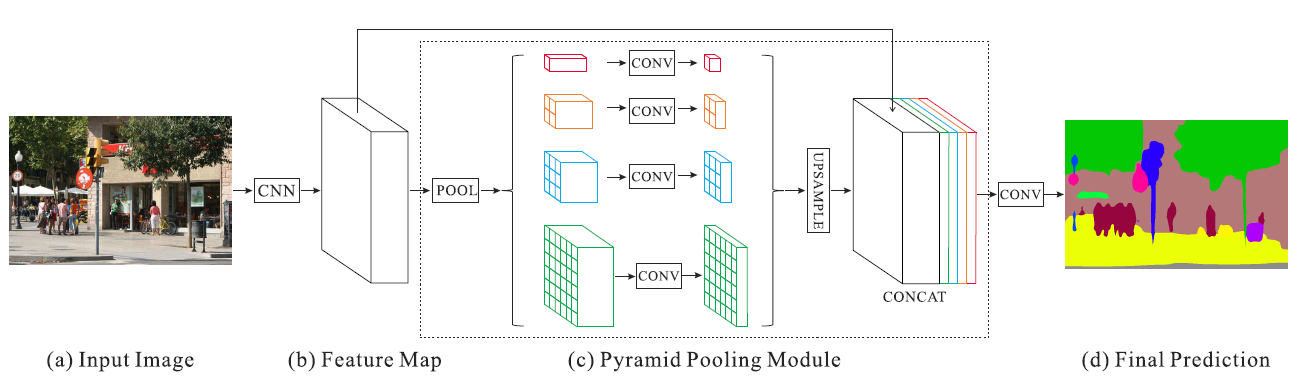

## Описание модели
### а) Входное изображение
### б) Карта признаков
Принимает входное изображение и вычисляет карты признаков для изображения. 
Построена на основе архитектуры ResNet
### c) Модуль объединения пирамид
Изображение содержит объекты размеров от небольшой до большой в разных областях изображения.В PSPNet, чтобы правильно сегментировать объекты всех размеров, карты признаков объединяются в пулы разного размера.

## Класс создания модели

In [22]:
class DanPSPNet:
  # --- НАСТРОЙКИ ---
  def __init__(self):
    pass

  # --- ГЕНЕРАЦИЯ СУБ-БЛОКОВ ДЛЯ ВХОДНОГО БЛОКА --- 
  def create_conv_block(self, X, filters, block_num):  # (X - входной слой, filters - количество нейронов, block_num - номер блока
    b = 'block_' + str(block_num) + '_'
    f1, f2, f3 = filters
    X_skip = X  # Вход для skip_conv блока

    # block_a
    X = Conv2D(filters=f1, kernel_size=(1, 1), dilation_rate=(1, 1), padding='same', kernel_initializer='he_normal', name=b + 'a')(X)
    X = BatchNormalization(name=b + 'batch_norm_a')(X)
    X = LeakyReLU(alpha=0.2,name=b + 'leakyrelu_a')(X)

    # block_b
    X = Conv2D(filters=f2, kernel_size=(3, 3), dilation_rate=(2, 2), padding='same', kernel_initializer='he_normal', name=b + 'b')(X)
    X = BatchNormalization(name=b + 'batch_norm_b')(X)
    X = LeakyReLU(alpha=0.2,name=b + 'leakyrelu_b')(X)

    # block_c
    X = Conv2D(filters=f3, kernel_size=(1,1), dilation_rate=(1,1), padding='same', kernel_initializer='he_normal', name=b + 'c')(X)
    X = BatchNormalization(name=b + 'batch_norm_c')(X)
  
    # skip_conv - слой идёт пралельно блокам a, b, c - для проброса признаков
    X_skip = Conv2D(filters=f3, kernel_size=(3,3), padding='same', name=b + 'skip_conv')(X_skip)
    X_skip = BatchNormalization(name=b + 'batch_norm_skip_conv')(X_skip)

    # block_c + skip_conv  # Пропускаем все слои и этот слой размещается от входа до выхода паралленьно 3 блокам a, b, c
    X = Add(name=b + 'add')([X, X_skip])
    X = ReLU(name=b + 'relu')(X)
    return X


  # --- ФОРМИРУЕМ ВХОДНОЙ БЛОК (ResNet) ---
  def create_base_block(self, input_layer):
    # block_1
    base = self.create_conv_block(input_layer,[32, 32, 64], '1')
    # block_2
    base = self.create_conv_block(base,[64, 64, 128], '2')
    # block_3
    base = self.create_conv_block(base,[128, 128, 256], '3')  # Разрешение небольшое, 3-й блок не нужен
    return base


  # --- СОЗДАНИЕ ПИРАМИДАЛЬНЫХ БЛОКОВ (PSPNet) ---
  def create_pyramidal_blocks(self, input_layer):
    # Red блок
    red = AveragePooling2D(pool_size=(1, 1), name='red_pool')(input_layer)  # Операция глобального среднего пула для пространственных данных.
    red = Conv2D(filters=64, kernel_size=(1, 1), name='red_C2D')(red)
    red = UpSampling2D(size=1, interpolation='bilinear', name='red_upsampling')(red)  # Слой передискретизации для 2D-входов. Удвоение строк и столбцов данных

    # Yellow блок
    yellow = AveragePooling2D(pool_size=(2, 2), name='yellow_pool')(input_layer)  # Операция глобального среднего пула для пространственных данных.
    yellow = Conv2D(filters=64, kernel_size=(1, 1), name='yellow_C2D')(yellow)
    yellow = UpSampling2D(size=2, interpolation='bilinear', name='yellow_upsampling')(yellow)
    
    # Blue блок
    blue = AveragePooling2D(pool_size=(4, 4),name='blue_pool')(input_layer)
    blue = Conv2D(filters=64,kernel_size=(1, 1),name='blue_C2D')(blue)
    blue = UpSampling2D(size=4, interpolation='bilinear', name='blue_upsampling')(blue)

    # Green блок
    green = AveragePooling2D(pool_size=(8, 8),name='green_pool')(input_layer)
    green = Conv2D(filters=64, kernel_size=(1, 1),name='green_C2D')(green)
    green = UpSampling2D(size=8,interpolation='bilinear',name='green_upsampling')(green)

    # Конкатенация базового входа и 4х приамидальных input_layer + red + yellow + blue + green
    return concatenate([input_layer, red, yellow, blue, green])


  # --- ПОСЛЕДНИЙ БЛОК СЕТИ ---
  def create_last_block(self, X):
    X = Conv2D(filters=3, kernel_size=3, padding='same', name='last_conv_3_by_3')(X)
    X = BatchNormalization(name='last_conv_3_by_3_batch_norm')(X)
    X = Conv2D(NUM_CLASSES, (3, 3), activation='softmax', padding='same')(X)
    # X = Activation('sigmoid', name='last_conv_relu')(X)
    # X = Flatten(name='last_conv_flatten')(X)
    return X


  # --- СОЗДАНИЕ МОДЕЛИ ---
  def create_model(self):
    input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
    input_layer = Input(input_shape)
    base = self.create_base_block(input_layer)
    pyramidal = self.create_pyramidal_blocks(base)
    output_layer = self.create_last_block(pyramidal)
    model = Model(inputs=input_layer, outputs=output_layer)
    self.model = model
    return model

## Создаём модель

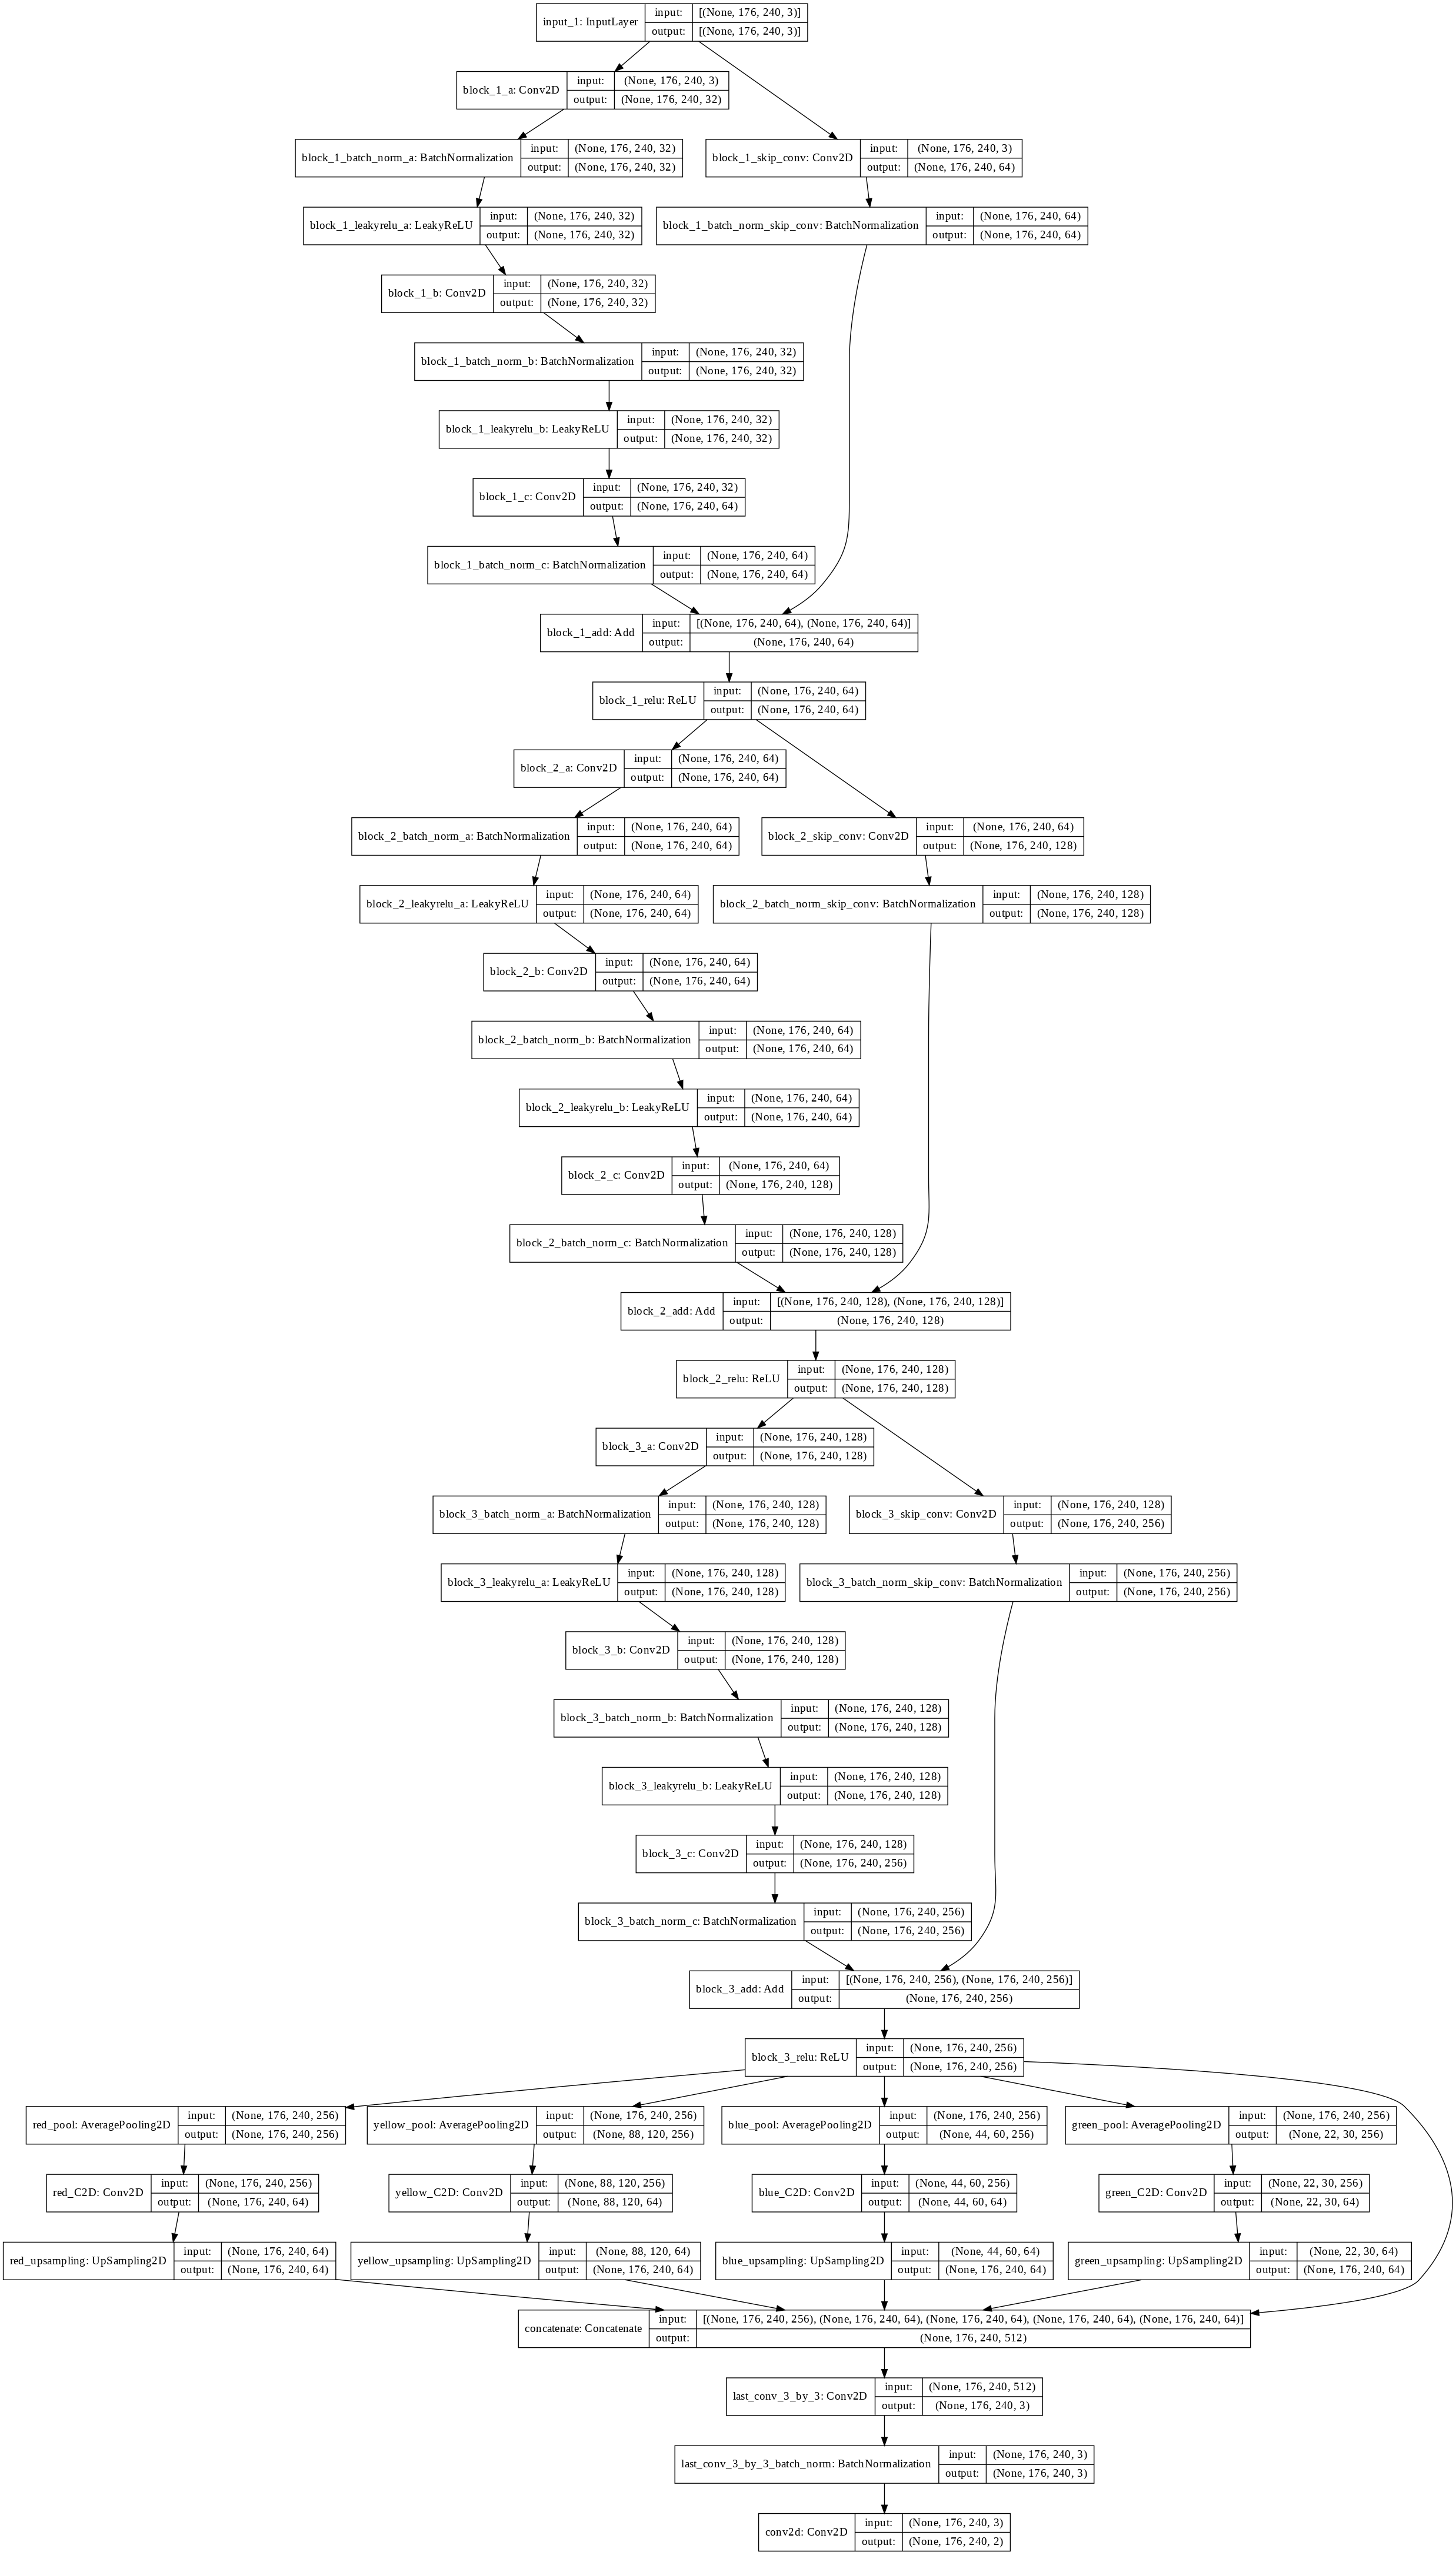

In [23]:
DAN = DanPSPNet()
model = DAN.create_model()

# Компилируем модель 
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[dice_coef])
plot_model(model, show_shapes=True, expand_nested=True, show_layer_names=True, dpi=100)

# Обучаем модель

In [34]:
print('TRAIN', x_train.shape, y_train.shape)
print('TEST', x_test.shape, y_test.shape)

history = model.fit(x_train, y_train, epochs=35, batch_size=16, validation_data = (x_test, y_test)) # Обучаем модель на выборке по двум классам

TRAIN (900, 176, 240, 3) (900, 176, 240, 2)
TEST (100, 176, 240, 3) (100, 176, 240, 2)
Epoch 1/35
57/57 [==============================] - 69s 1s/step - loss: 0.0381 - dice_coef: 0.9805 - val_loss: 0.0380 - val_dice_coef: 0.9820
Epoch 2/35
57/57 [==============================] - 72s 1s/step - loss: 0.0389 - dice_coef: 0.9802 - val_loss: 0.0415 - val_dice_coef: 0.9778
Epoch 3/35
57/57 [==============================] - 74s 1s/step - loss: 0.0377 - dice_coef: 0.9805 - val_loss: 0.1033 - val_dice_coef: 0.9394
Epoch 4/35
57/57 [==============================] - 75s 1s/step - loss: 0.0376 - dice_coef: 0.9804 - val_loss: 0.0452 - val_dice_coef: 0.9737
Epoch 5/35
57/57 [==============================] - 76s 1s/step - loss: 0.0364 - dice_coef: 0.9813 - val_loss: 0.0962 - val_dice_coef: 0.9369
Epoch 6/35
57/57 [==============================] - 77s 1s/step - loss: 0.0375 - dice_coef: 0.9809 - val_loss: 0.1608 - val_dice_coef: 0.9326
Epoch 7/35
57/57 [==============================] - 77s 1s/st

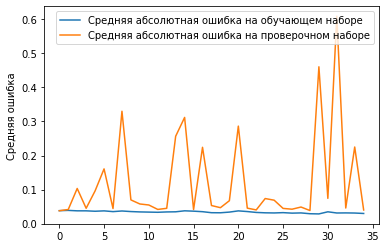

In [53]:
plt.plot(history.history['loss'], label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

# Распознавание изображений

Индексы: [62 27 59  7 39]


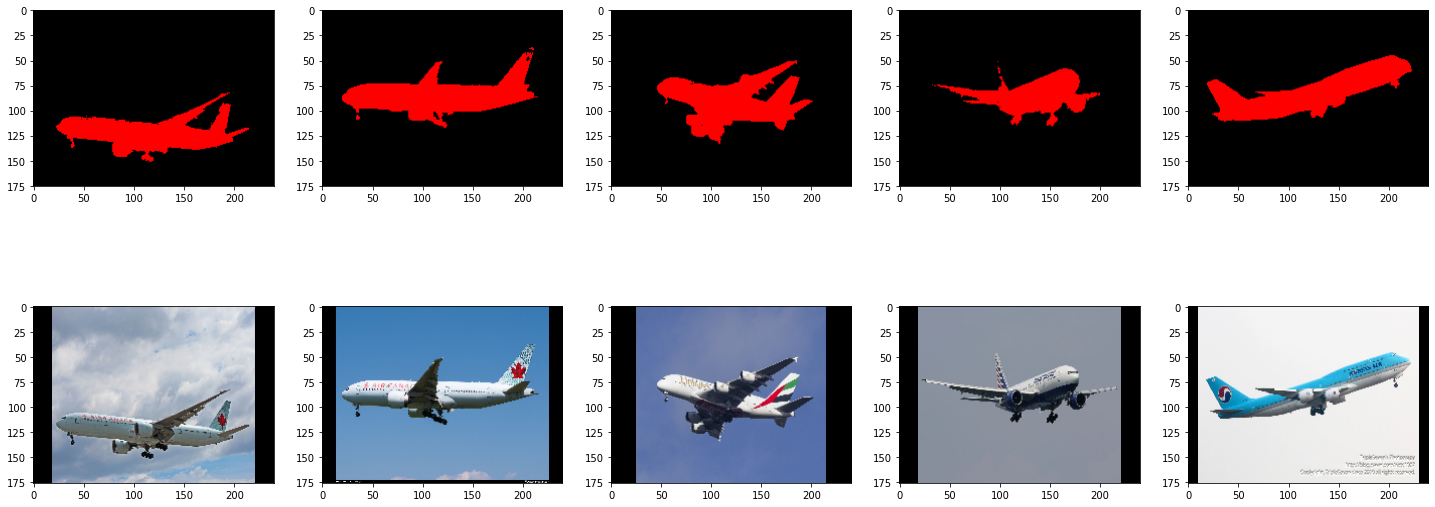

In [54]:
rand_count = 5  # Количество случайных изображений
indexes = np.random.randint(0, x_test.shape[0], rand_count)  # Получаем rand_count случайных индексов

print('Индексы:', indexes)

fig, axs = plt.subplots(nrows=2 , ncols=rand_count, figsize=(25, 10)) #Создаем полотно из n графиков
for i, idx in enumerate(indexes):
  predict = np.array(model.predict(x_test[idx].reshape(1, IMG_HEIGHT, IMG_WIDTH, 3)))
  pr = predict[0] # Берем нулевой элемент из перидкта, т.к. делаем предсказание в модели по одному изображению

  p_list = []
  for row in range(pr.shape[0]):  # Проходим по строкам изображений
    for col in range(pr.shape[1]):  # Проходим по колонкам изображений
      pi = np.argmax(pr[row, col])
      cat = index_to_color(pi)
      p_list.append(cat)    

  p = np.array(p_list)
  predict_image_segment = p.reshape(IMG_HEIGHT, IMG_WIDTH, 3)  # Решейпим к размеру изображения

  axs[0, i].imshow(predict_image_segment) # Отображаем фото
  axs[1, i].imshow(x_test[idx]) # Отображаем фото

plt.show()

# Наложение маски

(176, 240, 3)


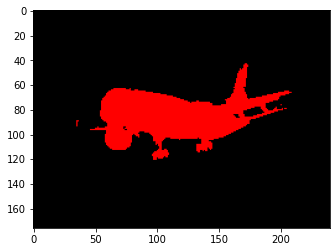

In [55]:
index = 12

predict = np.array(model.predict(x_test[index].reshape(1, IMG_HEIGHT, IMG_WIDTH, 3)))
pr = predict[0] # Берем нулевой элемент из перидкта, т.к. делаем предсказание в модели по одному изображению
p_list = []
for row in range(pr.shape[0]):  # Проходим по строкам изображений
  for col in range(pr.shape[1]):  # Проходим по колонкам изображений
    pi = np.argmax(pr[row, col])
    cat = index_to_color(pi)
    p_list.append(cat)    

p = np.array(p_list)
predict_image_segment = p.reshape(IMG_HEIGHT, IMG_WIDTH, 3)  # Решейпим к размеру изображения

print(predict_image_segment.shape)
seg = Image.fromarray(predict_image_segment.astype('uint8')).convert('RGBA')
plt.imshow(seg)

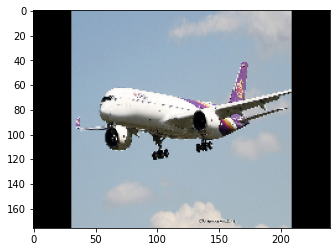

In [56]:
im = Image.fromarray((x_test[index]*255).astype('uint8')).convert('RGBA')
plt.imshow(im)

In [57]:
mask = np.array(seg)
mask[mask[:,:,0] <= 10] = [0, 0, 0, 0]
mask[mask[:,:,0] > 10] = [0, 255, 0, 150]

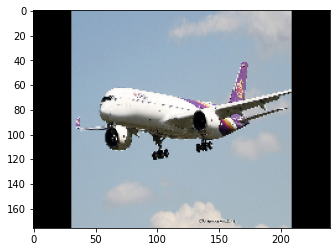

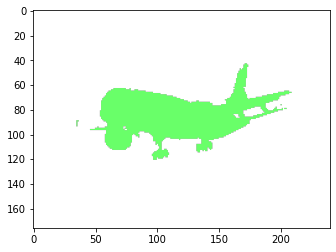

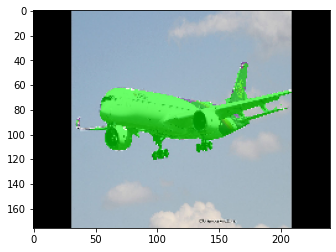

In [58]:
img2 = Image.fromarray((x_test[index]*255).astype('uint8'))
img = Image.fromarray(mask).convert('RGBA')

plt.imshow(img2)
plt.show()

img2.paste(img, (0, 0),img)
plt.imshow(img)
plt.show()
plt.imshow(img2)
plt.show()

# Вывод
Построил модель на основе PSPNet. Для извлечения карты признаков, входным блоком поставил нейрочеть на основе ResNet. Получил неплохой результат, даже немного лучше чем UNet.